In [1]:
import pandas as pd
import numpy as np

def format_func(value, tick_number):
    if value == 0:
        return "0"
    elif value >= 1000:
        return f"{int(value/1000)}k"
    else:
        return str(int(value))

def get_metric_values(df, input_type, metric_name):
    if input_type not in df["input_type"].unique():
        raise ValueError(f"'{input_type}' is not a valid input_type. "
                         f"Available: {df['input_type'].unique().tolist()}")
    if metric_name not in df["metric_name"].unique():
        raise ValueError(f"'{metric_name}' is not a valid metric_name. "
                         f"Available: {df['metric_name'].unique().tolist()}")
    
    metric_values = df[(df["input_type"] == input_type) &
                       (df["metric_name"] == metric_name)]["value"]
    return metric_values.values

def read_metrics(experiment_key: str) -> [pd.DataFrame, int]:
    experiment_metrics = pd.read_csv(f"loggs/{experiment_key}/metrics.csv")
    num_logged_epochs = experiment_metrics["epoch"].max() + 1
    return experiment_metrics, num_logged_epochs

def get_model_norm(results):
    return results[results["metric_name"] == "weights_l2"] \
        .groupby("epoch")["value"] \
        .apply(lambda x: np.sqrt((x**2).sum())).values

In [3]:
import collections
import math

log_frequency= 1
wd_best = collections.defaultdict(lambda: (math.inf, math.inf, math.inf))

for ar in [False, True]:
    for embedding in [False, True]:
        print(f"{ar=} {embedding=}")
        for hidden in range(1, 4):
            key = (ar, embedding, hidden)
            for lr in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]:
                for wd in range(2, 12, 2):
                    hidden_sizes = '' if hidden == 2 else f'|hidden_sizes-{[200] * hidden}' 
                    epochs = 10001 if not embedding and hidden == 1 else 401
                    input_size = '|input_size-100' if embedding else ''
                    use_embedding = '|use_embedding-True' if embedding else ''
                    all_reg = '|all_reg-True' if ar else ''
                    experiment_key = f'add_mod{hidden_sizes}|num_epochs-{epochs}|train_fraction-0.4{input_size}|log_frequency-1|lr-{lr}|batch_size-5107|weight_decay-{wd}.0{use_embedding}{all_reg}'
                    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
                    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)
            
                    test_acc = get_metric_values(experiment_metrics, "test", "accuracy")
                    s = (test_acc == 1.0)
                    index = np.where(s)[0]
                    if index.size > 0:
                        wd_best[key] = min((index[0], lr, wd), wd_best[key])

            print(wd_best[key])
        print()

ar=False embedding=False
(inf, inf, inf)
(inf, inf, inf)
(inf, inf, inf)

ar=False embedding=True
(174, 0.05, 6)
(163, 0.02, 6)
(186, 0.02, 2)

ar=True embedding=False
(917, 0.1, 2)
(143, 0.05, 4)
(inf, inf, inf)

ar=True embedding=True
(126, 0.05, 2)
(111, 0.05, 2)
(146, 0.01, 4)



In [6]:
ortho_best = collections.defaultdict(lambda: (math.inf, math.inf))

for default in [False, True]:
    for ar in [False, True]:
        for embedding in [False, True]:
            print(f"{default=} {ar=} {embedding=}")
            for hidden in range(1, 4):
                key = (default, ar, embedding, hidden)
                for lr in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]:
                    hidden_sizes = '' if hidden == 2 else f'|hidden_sizes-{[200] * hidden}' 
                    epochs = 10001 if not embedding and hidden == 1 else 401
                    input_size = '|input_size-100' if embedding else ''
                    use_embedding = '|use_embedding-True' if embedding else ''
                    all_reg = '|all_reg-True' if ar else ''
                    beta_epsilon = '|beta2-0.999|adam_epsilon-1e-08' if default else ''
                    experiment_key = f'add_mod{hidden_sizes}|num_epochs-{epochs}|train_fraction-0.4{input_size}|log_frequency-1|lr-{lr}|batch_size-5107|orthogonal_gradients-True{use_embedding}{all_reg}{beta_epsilon}'
                    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
                    
                    test_acc = get_metric_values(experiment_metrics, "test", "accuracy")
                    s = (test_acc == 1.0)
                    index = np.where(s)[0]
                    if index.size > 0:
                        ortho_best[key] = min((index[0], lr), ortho_best[key])

                print(ortho_best[key])
            print()

default=False ar=False embedding=False
(inf, inf)
(inf, inf)
(inf, inf)

default=False ar=False embedding=True
(inf, inf)
(235, 0.002)
(inf, inf)

default=False ar=True embedding=False
(1036, 0.05)
(124, 0.01)
(inf, inf)

default=False ar=True embedding=True
(266, 0.005)
(198, 0.002)
(inf, inf)

default=True ar=False embedding=False
(inf, inf)
(inf, inf)
(inf, inf)

default=True ar=False embedding=True
(inf, inf)
(231, 0.002)
(inf, inf)

default=True ar=True embedding=False
(2856, 0.05)
(125, 0.01)
(inf, inf)

default=True ar=True embedding=True
(inf, inf)
(196, 0.002)
(inf, inf)



In [12]:
print('||No Embedding Layer|Embedding Layer|')
print('|:-----:|:-----:|:-----:|')

ar = True
default = False

def f(v, b):
    if math.isinf(v):
        return f'>{b}'
    return str(v)

def fdiff(v, b):
    if math.isnan(v):  # math.inf - math.inf
        return '<gr>±?</gr>'
    if not v:
        return '<gr>±0</gr>'
    if v > 0:
        return f'<r>+{f(abs(v), b)}</r>'
    return f'<g>-{f(abs(v), b)}</g>'

for hidden in range(1, 4):
    print(f'|{hidden} Hidden Layer{(hidden > 1) * "s"}', end='')
    for embedding in [False, True]:
        wd_epoch = wd_best[ar, embedding, hidden][0]
        ortho_ep = ortho_best[default, ar, embedding, hidden][0]
        diff = wd_epoch - ortho_ep
        lower_bound = 10000 if not embedding and hidden == 1 else 400
        print('|' + f(wd_epoch, lower_bound) + ' ' + fdiff(diff, lower_bound - min(wd_epoch, ortho_ep)), end='')
    print('|')

||No Embedding Layer|Embedding Layer|
|:-----:|:-----:|:-----:|
|1 Hidden Layer|917 <g>-119</g>|126 <g>-140</g>|
|2 Hidden Layers|143 <r>+19</r>|111 <g>-87</g>|
|3 Hidden Layers|>400 <gr>±?</gr>|146 <g>->254</g>|


add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-2.0|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-4.0|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-6.0|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-8.0|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-10.0|all_reg-True


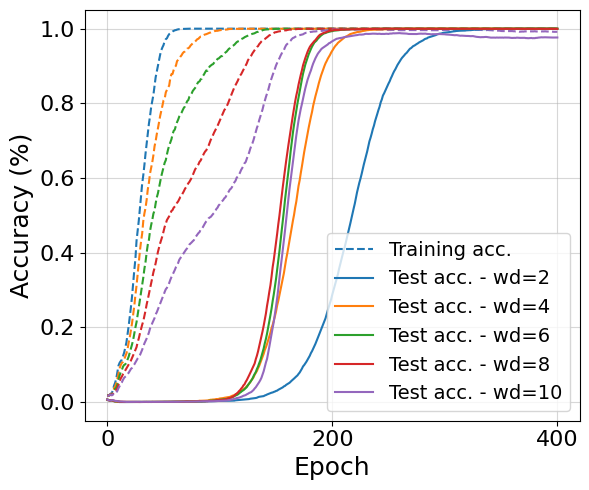

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

for wd in range(2, 12, 2):
    experiment_key = f'add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-{wd}.0|all_reg-True'
    print(experiment_key)
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0], linestyle='--', label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--')

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('figure_15a_repro_zoom_in.png')
plt.show()

add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|orthogonal_gradients-True|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-8.0|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-4.0|all_reg-True


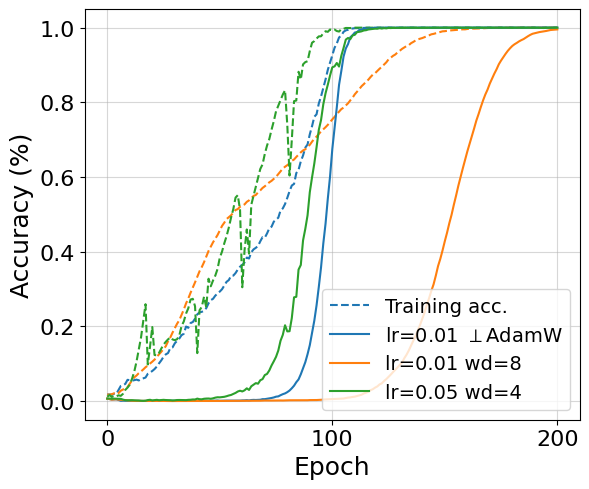

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

ar = True
embedding = False
hidden = 2
default=False

hidden_sizes = '' if hidden == 2 else f'|hidden_sizes-{[200] * hidden}' 
epochs = 10001 if not embedding and hidden == 1 else 401
input_size = '|input_size-100' if embedding else ''
use_embedding = '|use_embedding-True' if embedding else ''
all_reg = '|all_reg-True' if ar else ''
beta_epsilon = '|beta2-0.999|adam_epsilon-1e-08' if default else ''

lr = 0.01
experiment_key = f'add_mod{hidden_sizes}|num_epochs-{epochs}|train_fraction-0.4{input_size}|log_frequency-1|lr-{lr}|batch_size-5107|orthogonal_gradients-True{use_embedding}{all_reg}{beta_epsilon}'
print(experiment_key)
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

keys = []
for lr, wd in (lr_wd := [(0.01, 8), (0.05, 4)]):
    experiment_key = f'add_mod{hidden_sizes}|num_epochs-{epochs}|train_fraction-0.4{input_size}|log_frequency-1|lr-{lr}|batch_size-5107|weight_decay-{wd}.0{use_embedding}{all_reg}'
    print(experiment_key)
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

epochs = range(201) # range(0, log_frequency * (num_logged_epochs), log_frequency)
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0][:201], linestyle='--', label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc[:201], linestyle='--')

plt.gca().set_prop_cycle(None)

ax.plot(epochs, test_acc[0][:201], label=r'lr=0.01 $\perp$AdamW')
for (lr, wd), acc in zip(lr_wd, test_acc[1:]):
    ax.plot(epochs, acc[:201], label=f'{lr=} {wd=}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::100])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('best_experiments.png')
plt.show()

add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-2.0|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-4.0|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-6.0|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-8.0|all_reg-True
add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-10.0|all_reg-True


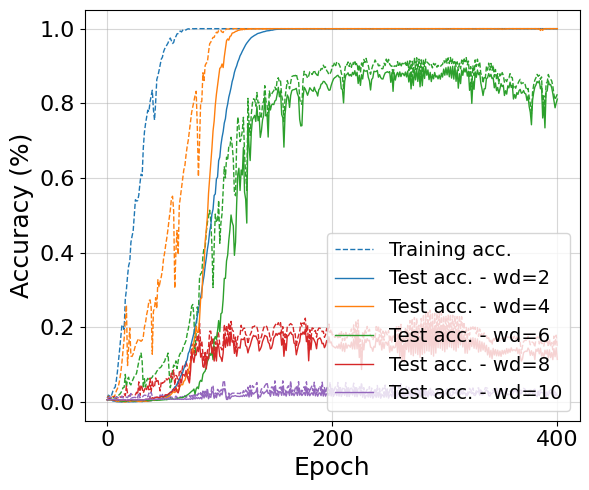

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []
epochs = 401

for wd in range(2, 12, 2):
    experiment_key = f'add_mod{hidden_sizes}|num_epochs-{epochs}|train_fraction-0.4{input_size}|log_frequency-1|lr-{lr}|batch_size-5107|weight_decay-{wd}.0{use_embedding}{all_reg}'
    print(experiment_key)
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    
    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)
ax.plot(epochs, train_acc[0], linestyle='--', linewidth=1, label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--', linewidth=1)

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, linewidth=1, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('high_lr_wd_experiments.png')
plt.show()